# Basic Chat Conversation - SystemMessage

In [4]:
#!pip install langgraph langchain[openai]

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount = True)

api_key_file = '/content/drive/MyDrive/api_key.txt'
with open(api_key_file, 'r', encoding = 'utf-8-sig') as file:
    api_key = file.read().strip()

print(api_key is not None)
os.environ['OPENAI_API_KEY'] = api_key
print("OpenAI API key loaded:", os.environ.get('OPENAI_API_KEY') is not None)

Mounted at /content/drive
True
OpenAI API key loaded: True


In [11]:
from langgraph.graph import StateGraph ,START, END
from typing_extensions import TypedDict, List
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage, SystemMessage
import os

llm = ChatOpenAI(model = 'gpt-4o-mini', temperature = 0)

class StateChat(TypedDict, total = False):
	messages: List[BaseMessage]           # Bases Messages -> Human, AI, System
	expert: str


SYSTEM_PROMPTS:dict = {'Lean Expert': "You are a Lean Manufacturing Consultant - Expert in waste reduction, continuous improvement, Kaizen, 5S, value stream mapping.",
					   'SCO Expert': "You are a Supply Chain Optimization Expert - Expert in inventory management, logistics, demand forecasting, supplier relationships."}

def answer_node(state: StateChat) -> dict:
    '''
    Take human question, get the expert type (if added), return AI response
    '''
    human: HumanMessage = state['messages'][-1]
    expert_key = state.get('expert')
    prompt_content = SYSTEM_PROMPTS.get(expert_key, "You are a helpful assistant.")          # If exist else random.
    sys_message = SystemMessage(content=prompt_content)
    ai_response: AIMessage = llm.invoke(input=[sys_message, human])
    return {'messages': [ai_response]}

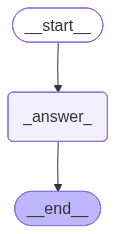

In [12]:
builder = StateGraph(StateChat)
builder.add_node('_answer_', answer_node)
builder.add_edge(start_key = START, end_key = '_answer_')
builder.add_edge(start_key = '_answer_', end_key = END)
graph = builder.compile()
graph

In [13]:
def response(message: str, history: List[List[str]], expert_choice: str) -> str:
    '''
    For Gradio usage
    '''
    inputs = {
        'messages': [HumanMessage(content=message)],
        'expert': expert_choice }

    result = graph.invoke(inputs)
    response_text = result['messages'][-1].content

    history = history + [[message, response_text]]
    return "", history

In [14]:
# Test
graph.invoke({'messages': [HumanMessage(content = 'What is SCO in few words?')], 'expert': 'SCO Expert'})['messages'][0].content

'SCO stands for Supply Chain Optimization, which involves improving the efficiency and effectiveness of supply chain operations to reduce costs, enhance service levels, and increase overall performance.'